In [1]:
## Import statements

import openmc
import openmc.deplete
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
from math import pi
import xml.etree.ElementTree as et
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Analysis Specifications
keffAnalyze = True
depletionAnalyze = True

In [3]:
# Dimensional Parameters

trisoPkFrac = 0.6 # ratio of triso particle volume to total pebble volume
pebblePkFrac = 0.64 # ratio of pebble volume to core volume

reflctThickness = 66 # cm
coreRadius = 50 # cm
coreHeight = 125 # cm

erchPercent = 19.75
U_form = 1;
O_form = 2;
rho_fuel = 10.96; # g/cm3

trisoPartThicknesses = [253.5, 97.7, 41.9, 37.5, 45.6]; # um

coolTemp = 450+273.15 #C -> K
coolPres = 8 #MPa

In [4]:
# Material Definitions

#      Buffer
buffer = openmc.Material(name='Buffer')
buffer.set_density('g/cm3', 1.0)
buffer.add_element('C', 1.0)

#      IPyC
IPyC = openmc.Material(name='IPyC')
IPyC.set_density('g/cm3', 1.9)
IPyC.add_element('C', 1.0)

#      SiC
SiC = openmc.Material(name='SiC')
SiC.set_density('g/cm3', 3.2)
SiC.add_element('C', 0.5)
SiC.add_element('Si', 0.5)

#      OPyC
OPyC = openmc.Material(name='OPyC')
OPyC.set_density('g/cm3', 1.87)
OPyC.add_element('C', 1.0)

# Moderator
graphite = openmc.Material()
graphite.set_density('g/cm3', 1.1995)
graphite.add_element('C', 1.0)

# Coolant
He = openmc.Material(name='He')
He.set_density('g/cm3',coolPres/coolTemp/2.0771)
He.add_element('He',1.0)
He.temperature = coolTemp

# Reflector
Refl = openmc.Material(name='Reflector')
Refl.set_density('g/cm3',1.72)
Refl.add_element('C',1.0)
Refl.add_s_alpha_beta('c_Graphite')


In [5]:
#TRISO Particle Volume Fraction Calculations
trisoPartRads = trisoPartThicknesses
for i in range(1,5):
    trisoPartRads[i] += trisoPartRads[i-1]
trisoPartVolFracs = trisoPartRads
for i in range(5):
    trisoPartVolFracs[i] = (trisoPartRads[i]/trisoPartRads[4])**3
for i in range(4):
    trisoPartVolFracs[4-i] -= trisoPartVolFracs[3-i]

In [6]:
#Pebble Volume Fraction Calculations
pebbleRads = [25, 30]
pebbleVolFracs = pebbleRads
for i in range(2):
    pebbleVolFracs[i] = (pebbleRads[i]/pebbleRads[1])**3
pebbleVolFracs[1] -= pebbleVolFracs[0]

In [7]:
trisoPkFrac = 60
erchPercent = .1975

In [8]:
#Fuel Kernel Material definition
fuel = openmc.Material(name="fuel")
fuel.set_density('g/cm3', rho_fuel)
fuel.add_nuclide('U235',erchPercent*U_form/(U_form+O_form))
fuel.add_nuclide('U238',((1-erchPercent)*U_form/(U_form+O_form)))
fuel.add_element('O', O_form/(U_form+O_form))
homogTrisoPart = openmc.Material.mix_materials([fuel, buffer, IPyC, SiC, OPyC], trisoPartVolFracs, 'vo')


In [9]:
#Enrichment Optimization

#B4
homogTrisoPebCore = openmc.Material.mix_materials([homogTrisoPart,graphite], [trisoPkFrac/100, 1-trisoPkFrac/100], 'vo')
homogTrisoPebble = openmc.Material.mix_materials([homogTrisoPebCore, graphite], pebbleVolFracs, 'vo')


#B7
homogCore = openmc.Material.mix_materials([homogTrisoPebble, He], [pebblePkFrac, 1-pebblePkFrac], 'vo',name='homogCore')
homogCore.add_s_alpha_beta('c_Graphite')
homogCore.volume = math.pi*50*50*125
materials = openmc.Materials()
materials += [Refl, homogCore]
materials.export_to_xml()

    #B8
core = openmc.model.RightCircularCylinder([0,0,0], 125, 50, axis='z', boundary_type = 'transmission')
rflctr = openmc.model.RightCircularCylinder([0,0,-reflctThickness],2*reflctThickness+125,reflctThickness+50, axis ='z',boundary_type = 'vacuum') 
rxr = openmc.Cell(fill=homogCore, region=-core)
reflect = openmc.Cell(fill = Refl, region =+core&-rflctr)
surr = openmc.Cell(region =+rflctr)
universe = openmc.Universe(cells=[rxr, reflect, surr])
geometry = openmc.Geometry()
geometry.root_universe = universe
geometry.export_to_xml()
settings = openmc.Settings()
settings.run_mode = 'eigenvalue'
settings.particles = 25000
settings.batches = 45
settings.inactive = 15
settings.temperature={'method':'interpolation','range':(250,2500)}
settings.export_to_xml()



#B9
#num_threads_des = 136  # set as desired.  Can be useful to ensure you do not take over all the resources for a machine
#num_threads = min(os.cpu_count(),num_threads_des); # prevent asking for more threads than OMP_NUM_THREADS

openmc.run(output=True)
sp = openmc.StatePoint('statepoint.45.h5')
keff = sp.keff
sp.close()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [10]:
mdl = openmc.model.Model(geometry, materials, settings)
op = openmc.deplete.CoupledOperator(mdl,"chain_endfb71_pwr.xml")
p = 5e6  # watts
#power =         [p,     p,  p, p, p, p,    p, p,    p,  0,  0,  0,    0]
#timesteps =     [.25, .25, .5, 1, 5, 14, 159, 185, 180, 1, 179, 185, 180]  # days
power = [p, p, p, 0, 0]
timesteps = [.5, 1.5, 180, 1, 180]
openmc.deplete.CECMIntegrator(op, timesteps, power, timestep_units='d').integrate()
results = openmc.deplete.Results("depletion_results.h5")

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading B11 from /home/m245244/omc_data/lib80x_hdf5/B11.h5
 Reading N14 from /home/m245244/omc_data/lib80x_hdf5/N14.h5
 Reading N15 from /home/m245244/omc_data/lib80x_hdf5/N15.h5
 Reading F19 from /home/m245244/omc_data/lib80x_hdf5/F19.h5
 Reading Ne20 from /home/m245244/omc_data/lib80x_hdf5/Ne20.h5
 Reading Ne21 from /home/m245244/omc_data/lib80x_hdf5/Ne21.h5
 Reading Ne22 from /home/m245244/omc_data/lib80x_hdf5/Ne22.h5
 Reading Na22 from /home/m245244/omc_data/lib80x_hdf5/Na22.h5
 Reading Na23 from /home/m245244/omc_data/lib80x_hdf5/Na23.h5


 Reading Mg24 from /home/m245244/omc_data/lib80x_hdf5/Mg24.h5
 Reading Mg25 from /home/m245244/omc_data/lib80x_hdf5/Mg25.h5
 Reading Mg26 from /home/m245244/omc_data/lib80x_hdf5/Mg26.h5
 Reading Al26_m1 from /home/m245244/omc_data/lib80x_hdf5/Al26_m1.h5
 Reading Al27 from /home/m245244/omc_data/lib80x_hdf5/Al27.h5
 Reading Si31 from /home/m245244/omc_data/lib80x_hdf5/Si31.h5
 Reading Si32 from /home/m245244/omc_data/lib80x_hdf5/Si32.h5
 Reading P31 from /home/m245244/omc_data/lib80x_hdf5/P31.h5
 Reading S32 from /home/m245244/omc_data/lib80x_hdf5/S32.h5
 Reading S33 from /home/m245244/omc_data/lib80x_hdf5/S33.h5
 Reading S34 from /home/m245244/omc_data/lib80x_hdf5/S34.h5
 Reading S35 from /home/m245244/omc_data/lib80x_hdf5/S35.h5
 Reading S36 from /home/m245244/omc_data/lib80x_hdf5/S36.h5
 Reading Cl35 from /home/m245244/omc_data/lib80x_hdf5/Cl35.h5
 Reading Cl36 from /home/m245244/omc_data/lib80x_hdf5/Cl36.h5
 Reading Cl37 from /home/m245244/omc_data/lib80x_hdf5/Cl37.h5
 Reading Ar36 

 Reading Cd114 from /home/m245244/omc_data/lib80x_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/m245244/omc_data/lib80x_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/m245244/omc_data/lib80x_hdf5/Cd116.h5
 Reading In113 from /home/m245244/omc_data/lib80x_hdf5/In113.h5
 Reading In114 from /home/m245244/omc_data/lib80x_hdf5/In114.h5
 Reading In115 from /home/m245244/omc_data/lib80x_hdf5/In115.h5
 Reading Sn112 from /home/m245244/omc_data/lib80x_hdf5/Sn112.h5
 Reading Sn113 from /home/m245244/omc_data/lib80x_hdf5/Sn113.h5
 Reading Sn114 from /home/m245244/omc_data/lib80x_hdf5/Sn114.h5
 Reading Sn115 from /home/m245244/omc_data/lib80x_hdf5/Sn115.h5
 Reading Sn116 from /home/m245244/omc_data/lib80x_hdf5/Sn116.h5
 Reading Sn117 from /home/m245244/omc_data/lib80x_hdf5/Sn117.h5
 Reading Sn118 from /home/m245244/omc_data/lib80x_hdf5/Sn118.h5
 Reading Sn119 from /home/m245244/omc_data/lib80x_hdf5/Sn119.h5
 Reading Sn120 from /home/m245244/omc_data/lib80x_hdf5/Sn120.h5
 Reading Sn121_m1 from /home/m2452

In [11]:
time, KEFF= results.get_keff()
time = time / (60*60*24*365.25);
keff_u = []
keff = []
for k in KEFF:
    keff_u.append(k[1])
    keff.append(k[0])


<ErrorbarContainer object of 3 artists>

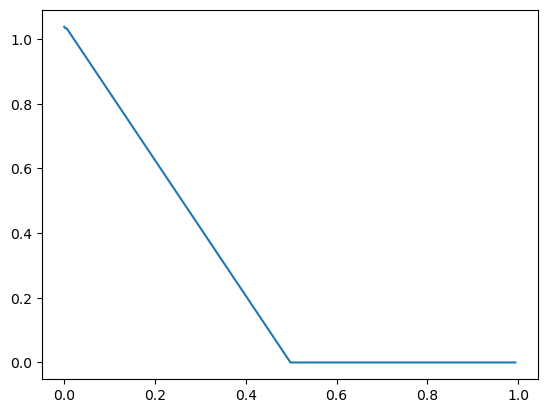

In [12]:
plt.errorbar(np.array(time), np.array(keff), np.array(keff_u))


In [13]:
# get depletion results to manipulate
r = openmc.deplete.Results('depletion_results.h5')
burned_mats = r.export_to_materials(burnup_index=10)
burned_mats.export_to_xml('BurnedMaterials10.xml')
mat_tree = et.parse('BurnedMaterials10.xml')
root = mat_tree.getroot()
i=0
for child in root:
    if child.attrib['name']=='homogCore':
        homogCore = root[i]
    i+=1
uo2_elem.set('id',23)
print(uo2_elem.items())
type(uo2_elem)
burned_uo2 = openmc.Material.from_xml_element(uo2_elem)
burned_uo2_mass = burned_uo2.get_mass()
listnuc = burned_uo2.get_nuclides() # list of nuclides present in burned fuel
import re
Puiso = []
for nuclide in listnuc:
    if re.search('Pu.+', nuclide):
        Puiso.append(nuclide)
pu_mass =0.
for nuclide in Puiso:
    pu_mass+=burned_uo2.get_mass(nuclide=nuclide)
pu_mass_fraction = pu_mass/burned_uo2_mass
SepPu = openmc.Material(name='PuProduct')
SepPu.set_density('g/cc',19.84) # density used for all metallic Plutonium in PNNL Compendium
print(Puiso)
i = len(Puiso)
n = 0
BurnPuAo = []
while (n < i):
    BurnPu = burned_uo2.get_nuclide_atom_densities(Puiso[n])
    BurnPuAo.append(BurnPu)
    SepPu.add_nuclide(Puiso[n],BurnPu[Puiso[n]])
    n+=1



IndexError: list index out of range

In [ ]:
def build_model(radius, fuel):
    
    
    materials = openmc.Materials([fuel])
    
    # create sphere with radius parameter
    sphere_radius = openmc.Sphere(x0=0,y0=0,z0=0,r=radius, boundary_type='vacuum', name='BCM')
    
    # create core cell
    core_cell = openmc.Cell(name='Bare Critical Sphere')
    core_cell.fill = fuel
    core_cell.region = -sphere_radius
    
    # create universe geometry
    root_universe = openmc.Universe(name='root universe')
    root_universe.add_cells([core_cell])
    
    geometry = openmc.Geometry(root_universe)
    # define criticality settings
    settings = openmc.Settings()
    settings.run_mode = 'eigenvalue' # keff calculation
    settings.particles = 5000 # particles per batch (mo betta)
    settings.batches = 250 # number of batches
    settings.inactive = 50 # inactive batches
    
    settings.output = {'tallies': False}
    
    model = openmc.model.Model(geometry,materials,settings)
    
    return model


In [ ]:
crit_r, guesses, keffs = openmc.search_for_keff(build_model, bracket=[1,50],model_args={'fuel':SepPu},
                                                tol=1e-4, print_iterations=True,
                                               run_args={'output':False})
# print results and collect data
print('Burned Plutonium Critical Mass')
print('The bare critical sphere radius is %7.4f cm.' % crit_r)
crit_v = 4/3*pi*crit_r**3 # volume of critical sphere (cc)

BCM = crit_v * 19.84 /1000 # mass of critical radius (kg)
print('The bare critical mass is %7.3f kg.' % BCM)

BCMs = np.array(BCM)
print(BCMs,
      '\n')